In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

In [2]:
def Convolution(input_tensor, filters, kernel_size, pool_type='max'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if pool_type == 'max':
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    return x

In [3]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    return x

In [4]:
def model_f(input_shape):
    inputs = Input(input_shape)

    conv_1 = Convolution(inputs, 64, (3, 3), 'max')
    conv_2 = Convolution(conv_1, 128, (5, 5), 'max')
    conv_3 = Convolution(conv_2, 256, (3,3), 'max')
    
    gap = Flatten()(conv_3)
    dense_0 = Dense_f(gap, 256)
    dense_1 = Dense_f(dense_0, 512)
    
    output = Dense(5, activation="softmax")(dense_1)
    model = Model(inputs=inputs, outputs=output)

    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [5]:
model = model_f((64,64,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0     

In [6]:
image_size = 64
batch_size = 64
epochs = 100

datagen_train = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=10, 
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = datagen_train.flow_from_directory(
    "UTKE/Train/",
    target_size=(image_size, image_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

datagen_validation = ImageDataGenerator(rescale=1./255)

validation_generator = datagen_validation.flow_from_directory(
    "UTKE/Test/",
    target_size=(image_size, image_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 13898 images belonging to 5 classes.
Found 5960 images belonging to 5 classes.


In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

epochs = 50
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("ethnicity_model_weights.weights.h5", monitor='val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint, early_stopping, reduce_lr]

In [8]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks
)

Epoch 1/50
217/217 [==============================] - ETA: 0s - loss: 1.6941 - accuracy: 0.3557
Epoch 1: saving model to ethnicity_model_weights.weights.h5
217/217 [==============================] - 282s 1s/step - loss: 1.6941 - accuracy: 0.3557 - val_loss: 1.7334 - val_accuracy: 0.2273 - lr: 5.0000e-04
Epoch 2/50
217/217 [==============================] - ETA: 0s - loss: 1.3628 - accuracy: 0.4753
Epoch 2: saving model to ethnicity_model_weights.weights.h5
217/217 [==============================] - 281s 1s/step - loss: 1.3628 - accuracy: 0.4753 - val_loss: 1.6466 - val_accuracy: 0.3501 - lr: 5.0000e-04
Epoch 3/50
217/217 [==============================] - ETA: 0s - loss: 1.1749 - accuracy: 0.5502
Epoch 3: saving model to ethnicity_model_weights.weights.h5
217/217 [==============================] - 292s 1s/step - loss: 1.1749 - accuracy: 0.5502 - val_loss: 1.4674 - val_accuracy: 0.4362 - lr: 5.0000e-04
Epoch 4/50
217/217 [==============================] - ETA: 0s - loss: 1.0868 - accura

In [9]:
model.evaluate(validation_generator)

94/94 [==============================] - 23s 248ms/step - loss: 0.6870 - accuracy: 0.7482


[0.6870263814926147, 0.74815434217453]

In [10]:
model_json = model.to_json()
with open("model_ethnicity.json","w") as json_file:
    json_file.write(model_json)

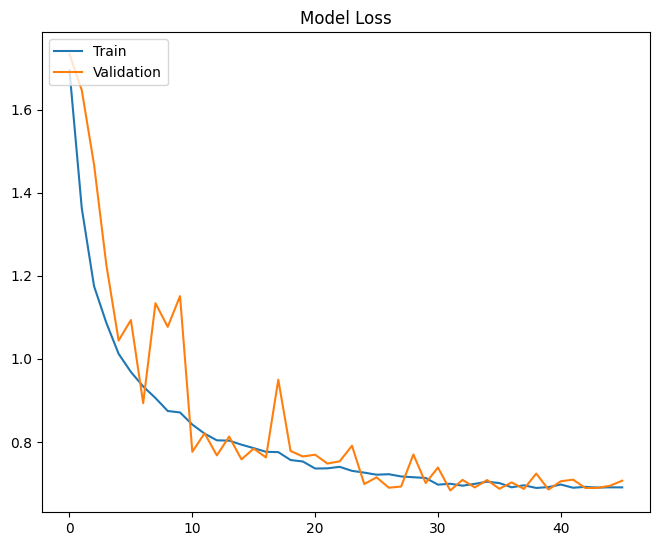

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.subplots_adjust(top=1.0,bottom=0.0, right=0.95,left=0.0,hspace=0.25,wspace=0.35)

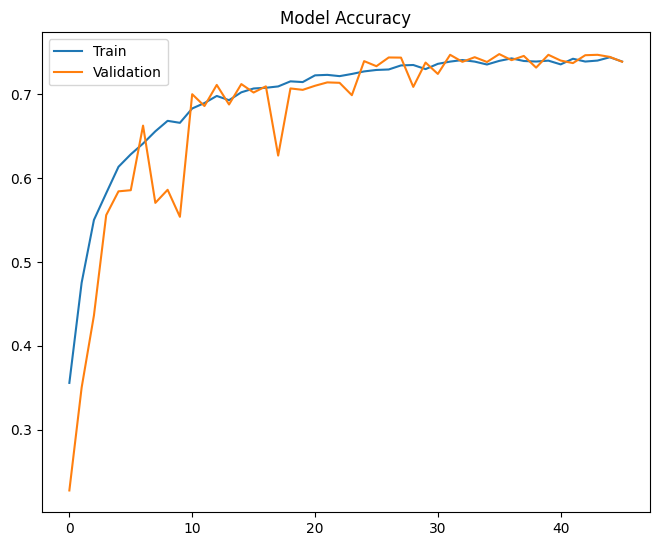

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.subplots_adjust(top=1.0,bottom=0.0, right=0.95,left=0.0,hspace=0.25,wspace=0.35)